# Credit Risk Machine Learning Model

Credit modelling is an important part of determining risk when offering loans to potential borrowers. If a borrower does not pay their loan back on time, the investor will lose money.

In a previous notebook I have taken Lending Club data from 2007 to 2011 and cleaned it. In this notebook I will be building the machine learning model to predict whether a borrower will pay back on time.

The machine learning model will be built from a conservative investors perspective, hoping to invest (predict) only in loans that will have a good chance of being paid off on time. In this regard we are interested in the true positive rate. However the false positive rate is also very important as we do not want to invest in a loan that will not be paid back. It is important to have a good trade off between these rates, as often improving one worsens the other. We will measure the performance of the model through ROC curves and confusion matrices.

## Exploring the Data

In [1]:
# importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, auc
from imblearn.over_sampling import SMOTENC
%matplotlib inline

In [2]:
# read clean dataset to pandas dataframe
loans = pd.read_csv('clean_loans_2007.csv')
# drop rogue col
loans.drop('Unnamed: 0', axis=1, inplace=True)
loans.head()

,loan_amnt,term,int_rate,installment,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,last_credit_pull_d,pub_rec_bankruptcies
0,5000.0,36 months,10.65%,162.87,10+ years,RENT,24000.0,Verified,1,credit_card,...,0.0,Jan-1985,1.0,3.0,0.0,13648.0,83.7%,9.0,Jun-2016,0.0
1,2500.0,60 months,15.27%,59.83,< 1 year,RENT,30000.0,Source Verified,0,car,...,0.0,Apr-1999,5.0,3.0,0.0,1687.0,9.4%,4.0,Sep-2013,0.0
2,2400.0,36 months,15.96%,84.33,10+ years,RENT,12252.0,Not Verified,1,small_business,...,0.0,Nov-2001,2.0,2.0,0.0,2956.0,98.5%,10.0,Jun-2016,0.0
3,10000.0,36 months,13.49%,339.31,10+ years,RENT,49200.0,Source Verified,1,other,...,0.0,Feb-1996,1.0,10.0,0.0,5598.0,21%,37.0,Apr-2016,0.0
4,5000.0,36 months,7.90%,156.46,3 years,RENT,36000.0,Source Verified,1,wedding,...,0.0,Nov-2004,3.0,9.0,0.0,7963.0,28.3%,12.0,Jan-2016,0.0


## Removing Null Values

First we will explore columns with null values, and decide whether to keep them and what to do with the null values of columns we do keep.

In [3]:
# find number of null values in each column
null_counts = loans.isnull().sum()

# filter only for counts > 0
null_counts[null_counts != 0]

emp_length              1036
title                     11
revol_util                50
last_credit_pull_d         2
pub_rec_bankruptcies     697
dtype: int64

*emp_length* and *pub_rec_bankruptcies* have a relatively large number of missing values. Employment length is important in determining credit risk, so we should keep this feature.

In [4]:
# print normalised value counts for pub_rec_bankruptcies
loans['pub_rec_bankruptcies'].value_counts(normalize=True, dropna=False)

0.0    0.939438
1.0    0.042456
NaN    0.017978
2.0    0.000129
Name: pub_rec_bankruptcies, dtype: float64

*pub_rec_bankruptcies* offers little variability, so we can drop this col. We will also drop all rows with null values for cols we have kept.

In [5]:
# drop pub_rec_bankruptcies col
loans.drop('pub_rec_bankruptcies', axis=1, inplace=True)

# drop rows with null values
loans.dropna(axis=0, inplace=True)

## Dealing with non-Numerical Features

In [6]:
# check data types in dataframe
loans.dtypes.value_counts()

object     11
float64    10
int64       1
dtype: int64

In [7]:
# create new dataframe of only object types and print
objects = loans.select_dtypes('object')
objects.head(1)

,term,int_rate,emp_length,home_ownership,verification_status,purpose,title,addr_state,earliest_cr_line,revol_util,last_credit_pull_d
0,36 months,10.65%,10+ years,RENT,Verified,credit_card,Computer,AZ,Jan-1985,83.7%,Jun-2016


Consulting the data dictionary it was found:

- *home_ownership* - can be only 1 of 4 categorical values
- *verification_status* - indicates if the income was verified by Lending Club
- *emp_length* - number of years the borrower was employed upon time of application
- *term* - number of payments on the loan, either 36 or 60
- *addr_state* - borrower's state of residence
- *purpose* - provided by the borrower
- *title* - loan title provided by the borrower
- *int_rate* - interest rate of the loan in %
- *revol_util* - revolving line utilisation rate or the amoun of redit the borrower is using relative to all available credit
- *earliest_cr_line* - the month the borrower/s earliest reported credit line was opened
- *last_credit_pull_d* - the most recent month Lending Club pulled credit for this loan

It looks like *purpose* and *title* reflect the same information.

The date columns will require significant feature engineering for a potentially unequivalent gain.

The *int_rate* and *revol_util* cols contain numerical information and need to be converted.

Exploring the other columns:

In [8]:
# list of cols to explore
object_cols = ['home_ownership',
               'verification_status',
               'emp_length',
               'term',
               'addr_state']

# print normalised value counts of cols to explore
for col in object_cols:
    print(loans[col].value_counts(normalize=True), '\n')

RENT        0.480743
MORTGAGE    0.442893
OWN         0.073736
OTHER       0.002548
NONE        0.000080
Name: home_ownership, dtype: float64 

Not Verified       0.432143
Verified           0.314691
Source Verified    0.253165
Name: verification_status, dtype: float64 

10+ years    0.226808
< 1 year     0.119788
2 years      0.114214
3 years      0.106755
4 years      0.088998
5 years      0.084990
1 year       0.084300
6 years      0.057784
7 years      0.045494
8 years      0.038275
9 years      0.032595
Name: emp_length, dtype: float64 

 36 months    0.749409
 60 months    0.250591
Name: term, dtype: float64 

CA    0.179854
NY    0.095926
FL    0.071772
TX    0.069356
NJ    0.047140
IL    0.038407
PA    0.038275
VA    0.035753
GA    0.035116
MA    0.033762
OH    0.030498
MD    0.026755
AZ    0.021420
WA    0.020916
CO    0.019854
NC    0.019350
CT    0.018872
MI    0.017996
MO    0.017200
MN    0.015421
NV    0.012369
SC    0.012050
WI    0.011334
OR    0.011201
LA    0.011148
A

These columns contain multiple discrete values that need to be encoded. The *emp_length* column also needs to be cleaned.

Exploring the *purpose* and *title* columns confirms that they contain similar information. However *purpose* contains fewer discrete values so we shall remove *title*.

In [9]:
print(loans['title'].value_counts(normalize=True), '\n')
print(loans['purpose'].value_counts(normalize=True))

Debt Consolidation                  0.054891
Debt Consolidation Loan             0.042442
Personal Loan                       0.016563
Consolidation                       0.012953
debt consolidation                  0.012369
                                      ...   
Quickrepay                          0.000027
baby09                              0.000027
Casinobill                          0.000027
Please help us with our wedding!    0.000027
personal home improvements          0.000027
Name: title, Length: 18881, dtype: float64 

debt_consolidation    0.471161
credit_card           0.130352
other                 0.098500
home_improvement      0.074532
major_purchase        0.055289
small_business        0.045627
car                   0.038726
wedding               0.024313
medical               0.017386
moving                0.014652
house                 0.009449
vacation              0.009237
educational           0.008281
renewable_energy      0.002495
Name: purpose, dtype: floa

In [10]:
# drop features
loans.drop(['last_credit_pull_d',
            'addr_state',
            'title',
            'earliest_cr_line'], axis=1, inplace=True)

In [11]:
# clean emp_length column using mapping dict
mapping = {'10+ years': 10,
           '9 years': 9,
           '8 years': 8,
           '7 years': 7,
           '6 years': 6,
           '5 years': 5,
           '4 years': 4,
           '3 years': 3,
           '2 years': 2,
           '1 year': 1,
           '< 1 year': 0,
           "n/a":0
          }

# map dict to emp_length column
loans['emp_length'].replace(mapping, inplace=True)

In [12]:
# clean and format int_rate and revol_util cols
loans['int_rate'] = loans['int_rate'].str.strip('%').astype('float')
loans['revol_util'] = loans['revol_util'].str.strip('%').astype('float')

### Checking Collinearity

Now we have removed all null values and kept relevant features, we will check for collinearity between features in the dataset.

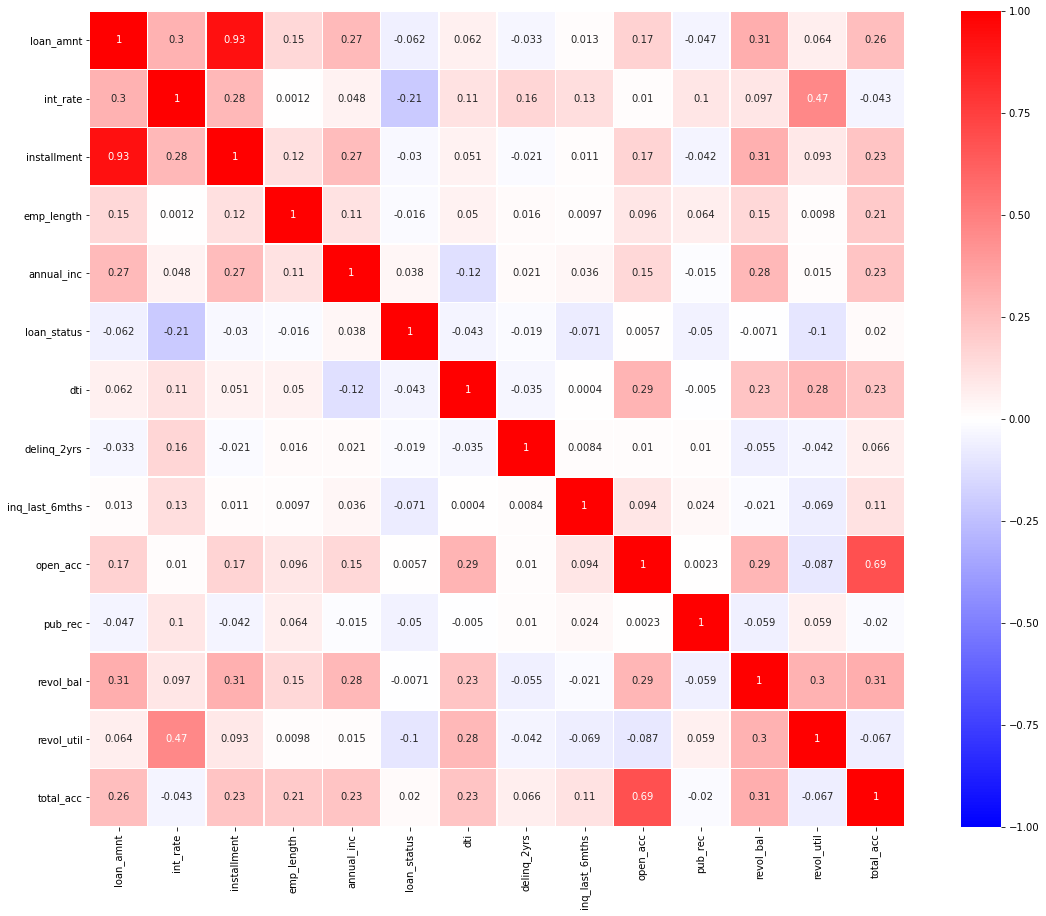

In [13]:
# plot heatmap of correlation between features
plt.figure(figsize=(20,15))
sns.heatmap(loans.corr(), annot=True, cmap='bwr',vmin=-1, vmax=1, square=True, linewidths=0.5)

There seems to be a strong correlation between *loan_amnt* and *installment*, we will drop the *installment* feature as *laon_amnt* provides more information.

*open_acc* and *total_acc* are also quite strongly related. We will keep *total_acc* and this contains more information on credit lines than *open_acc*.

In [14]:
loans.drop(['installment', 'open_acc'], axis=1, inplace=True)

### Creating Dummy Variables

It is now necessary to convert the remaining categorical variables to dummy variables.

In [15]:
# set variables to categorical type
cols = [
    'home_ownership',
    'verification_status',
    'purpose',
    'term'
]

for col in cols:
    loans[col] = loans[col].astype('category')

# create dummy variables for the categorical features
loans = pd.concat([loans,
                 pd.get_dummies(loans[['home_ownership',
                                       'verification_status',
                                       'purpose',
                                      'term']])], axis=1)

# drop original cols
loans.drop(['home_ownership',
            'verification_status',
            'purpose',
            'term'], axis=1, inplace=True)

In [16]:
# check dataframe info
loans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37675 entries, 0 to 38769
Data columns (total 36 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   loan_amnt                            37675 non-null  float64
 1   int_rate                             37675 non-null  float64
 2   emp_length                           37675 non-null  int64  
 3   annual_inc                           37675 non-null  float64
 4   loan_status                          37675 non-null  int64  
 5   dti                                  37675 non-null  float64
 6   delinq_2yrs                          37675 non-null  float64
 7   inq_last_6mths                       37675 non-null  float64
 8   pub_rec                              37675 non-null  float64
 9   revol_bal                            37675 non-null  float64
 10  revol_util                           37675 non-null  float64
 11  total_acc                   

# Building the Model

The algorithm will make predictions about whether or not a loan will be paid off on time, which is contained in the *loan_status* column of the clean dataset. The problem is therefore a binary classification problem.

The *loan_status* column has a significant class imbalance: there are 6 times as many loans that were paid off on time (labelled 1) than those that weren't (labelled 0).

Due to this, the true positive rate and false positive rate are important to test our model. In context:

- *true positive rate* - the model has correctly predicted whether a loan will be paid off on time, we will not lose money by investing
- *false positive rate* - the model has incorrectly predicted that a loan will be paid off on time when it won't be, we will lose money by investing

Ideally we need to maximise the true positive rate and minimise the false positive rate, corresponding to a high AUC score which will therefore be the error metric we will use.

The classification models we will use are:

- logistic regression
- random forests
- linear discriminant analysis

We will quickly fit basic models to the training set and validate on the test set to discover which models to take forward for further model building.

### Splitting Test and Training Datasets

We will split the dataset into a 70:30 train test split. We will keep a master copy of the X training set as we will be undertaking SMOTE later so will need the non-scaled data.

In [17]:
# identify feature and target matrices
features = loans[loans.columns.drop('loan_status')]
target = loans['loan_status']

# split dataset into train and test splits
X_train_master, X_test, y, y_test = train_test_split(features, target, train_size=0.7, random_state=1, stratify=target)

### Scaling Numerical Features

The numerical features will be scaled to zero mean and unit variance. The same transformation will be applied on the test set data for consistency.

In [18]:
# suppress settingwithcopy warning
pd.options.mode.chained_assignment = None

# create a copy of the master train data to perform scaling on
X = X_train_master.copy()

# identify numerical columns to be standardised
numerical = X.columns[(X.dtypes == 'float64') | (X.dtypes == 'int64')].tolist()

# standardise numerical features in training dataset
scaler = StandardScaler()
X[numerical] = scaler.fit_transform(X[numerical])

# apply identical transformation to test set for consistency
X_test[numerical] = scaler.fit_transform(X_test[numerical])

### Model Selection

The models we will choose to test are:
 - Logistic Regression
 - Random Forests
 - Gaussian Naive Bayes
 - Linear Discriminant Analysis
 
We will score the models using ROC-AUC scoring and take forward the best performing model.

In [19]:
# models to test
models = {
    'Logistic Regression': LogisticRegression(max_iter=500),
    'Random Forests': RandomForestClassifier(),
    'Gaussian Naive Bayes': GaussianNB(),
    'Linear Discriminant': LinearDiscriminantAnalysis()
}

# empty dict for scoring data
scoring = {}
rocs = {}
confs = {}

# for each model calculate average auc score, roc curve and tp and fp for confusion matrix
for i in models.keys():
    
    scores = cross_val_score(models[i], X, y, scoring='roc_auc', cv=3)
    scoring[i] = np.mean(scores)
    
    models[i].fit(X, y)
    
    probs = models[i].predict_proba(X_test)
    
    fp, tp, threshold = roc_curve(y_test, probs[:,1])
    rocs[i] = {'fps': fp, 'tps': tp}
    
    conf = confusion_matrix(y_test, models[i].predict(X_test)).T
    conf = conf.astype('float') / conf.sum(axis=0)
    confs[i] = conf
    

                      auc_score
Logistic Regression    0.701075
Linear Discriminant    0.696740
Random Forests         0.684836
Gaussian Naive Bayes   0.648341


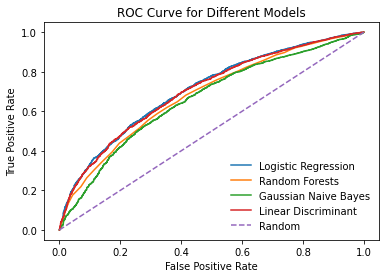

In [20]:
# plot ROC curves
fig = plt.figure()
ax = plt.axes()

for i in models.keys():
    ax.plot(rocs[i]['fps'], rocs[i]['tps'], label=i)

plt.plot([0,1], [0,1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Different Models')
plt.legend(frameon=False)

# show auc score results
print(pd.DataFrame.from_dict(scoring, orient='index', columns=['auc_score']).sort_values(by='auc_score', ascending=False))

Text(0.04, 0.5, 'Predicted Value')

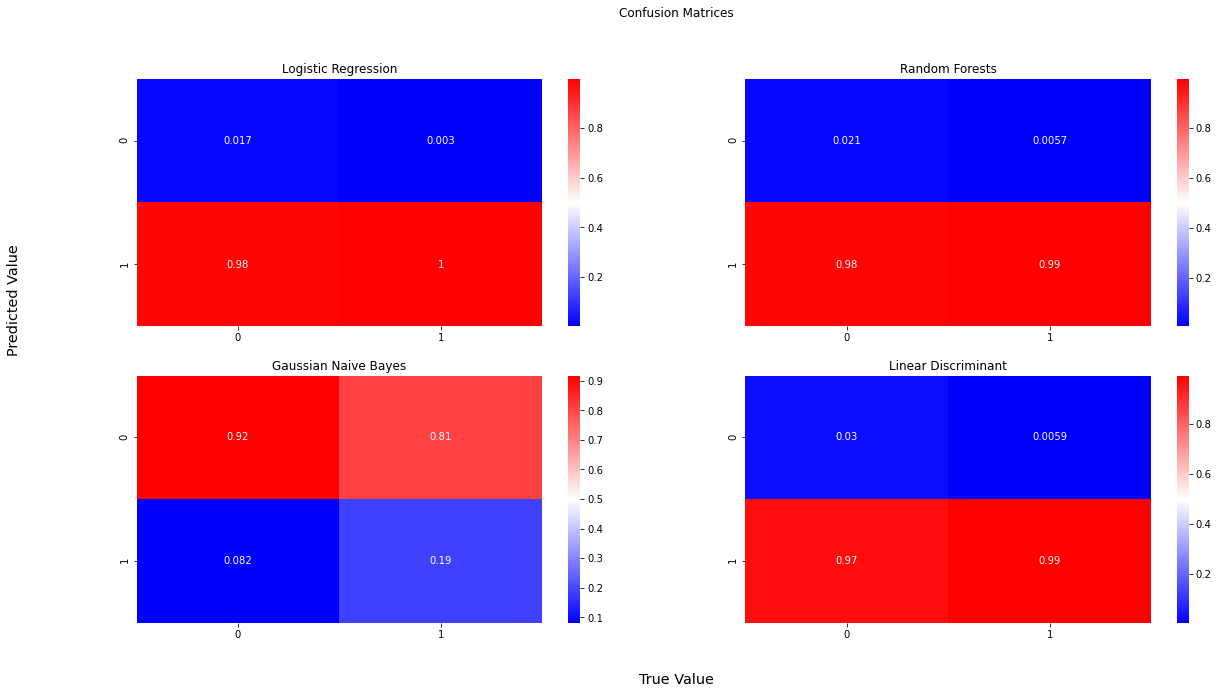

In [21]:
# plot confusion matrices
fig, ax = plt.subplots(2, 2)
fig.set_figheight(10)
fig.set_figwidth(20)
fig.suptitle('Confusion Matrices')

sns.heatmap(confs['Logistic Regression'], annot=True, cmap='bwr', ax=ax[0,0])
sns.heatmap(confs['Random Forests'], annot=True, cmap='bwr', ax=ax[0,1])
sns.heatmap(confs['Gaussian Naive Bayes'], annot=True, cmap='bwr', ax=ax[1,0])
sns.heatmap(confs['Linear Discriminant'], annot=True, cmap='bwr', ax=ax[1,1])

ax[0,0].set_title('Logistic Regression')
ax[0,1].set_title('Random Forests')
ax[1,0].set_title('Gaussian Naive Bayes')
ax[1,1].set_title('Linear Discriminant')
fig.text(0.5, 0.04, 'True Value', ha='center', fontsize='x-large')
fig.text(0.04, 0.5, 'Predicted Value', ha='center', fontsize='x-large', rotation='vertical')

Investigating the results, we can see that the Logistic Regression model performed the best out of the 4 models with regards to its AUC score. 

Considering the confusion matrix however we can see that the false positive rate is quite high, which is not good in the context of investing in loans that won't be paid back on time

There are several techniques we can include such as grid searching, threshold-moving and sampling techniques to optimise the logistic regression model.

# Logistic Regression Optimisation

### Using Different Class Weight Penalties

Lets first perform a grid search on the logistic regression model using different *class_weight* penalties, *solver* types and *C* regularisation penalties.

To find the optimum model with regards to true positive and false positive rates, we will also conduct threshold-moving and find the best threshold with regards to the ROC curve. First, lets define true positive and false positive rates.

- the true positive rate (sensitivity) is $tp = \frac{tp}{tp + fn}$
- the false positive rate (1 - specificity) is $fp = \frac{fp}{fp + tn}$

The ROC curve plots the TPR against FPR for different thresholds. Finding the optimum threshold which gives the best balance of TPR and FPR will optimise the model.

The G-means metric will be used to do this. If optimised, the G-means metric will seek a balance between TPR and FPR.

$G-Mean = sqrt(TPR * (1 - FPR))$

We will find the largest G-means value from the thresholds studied, and this will indicate the optimum threshold point.

In [22]:
# check value counts of target col
y.value_counts(normalize=True)

1    0.85697
0    0.14303
Name: loan_status, dtype: float64

In [23]:
# create parameter grid
hyperparameters = {
    'class_weight': ['balanced', {0: 8, 1: 1}, {0: 10, 1: 1}],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'C': [0.3, 0.5, 1]
}

# conduct grid searching of logistic regression model
grid = GridSearchCV(models['Logistic Regression'], param_grid=hyperparameters, cv=3, scoring='roc_auc')
grid.fit(X, y)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.3, 0.5, 1],
                         'class_weight': ['balanced', {0: 8, 1: 1},
                                          {0: 10, 1: 1}],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

Having found the best logistic regression model hyperparameters, we will now conduct threshold moving and find the optimum threshold. Then we will plot the ROC curve and confusion matrix for the results.

Text(0.5, 1.0, 'Confusion Matrix for Best Regression Model using Class Weight Penalties')

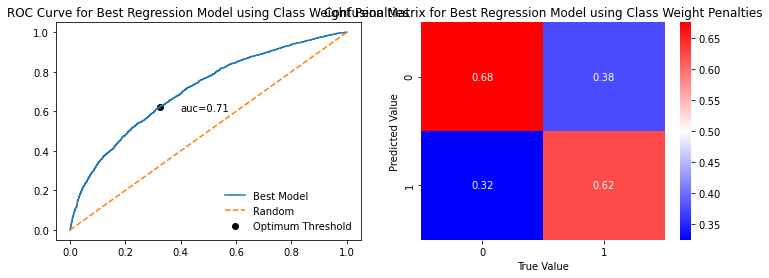

In [24]:
# fit the best model to the data
grid.best_estimator_.fit(X, y)

# compute prediction probabilities
probs_best = grid.best_estimator_.predict_proba(X_test)

# compute false positives, true positives and corresponding thresholds for roc curve plotting
fp, tp, threshold = roc_curve(y_test, probs_best[:,1])

# compute auc score metric
auc = roc_auc_score(y_test, probs_best[:,1])

# compute gmeans metric to identify optimum threshold for regression
gmeans = (tp * (1-fp))**0.5

# index the maximum gmean
ix = np.argmax(gmeans)

# locate the optimum threshold value
opt_threshold = threshold[ix]

# predict labels using optimum threshold
predict = np.where(probs_best[:,1] >= opt_threshold, 1, 0)

# plot confusion matrix using optimum threshold
conf = confusion_matrix(y_test, predict).T
conf = conf.astype('float') / conf.sum(axis=0)

# plot roc curve and confusion matrix
fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
ax[0].plot(fp, tp, label='Best Model')
ax[0].plot([0,1], [0,1], linestyle='--', label='Random')
ax[0].scatter(fp[ix], tp[ix], marker='o', color='black', label='Optimum Threshold')
ax[0].text(0.4, 0.6, 'auc={}'.format(round(auc, 2)))
ax[0].set_title('ROC Curve for Best Regression Model using Class Weight Penalties')
ax[0].legend(loc='lower right', frameon=False)
sns.heatmap(conf, annot=True, cmap='bwr', ax=ax[1])
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
ax[1].set_title('Confusion Matrix for Best Regression Model using Class Weight Penalties')

Using the optimum threshold has improved the model. The AUC score has improved, but more importantly the true positive and true negative rates are much more balanced. From an investors perspective, we can be fairly confident using the model that we will be investing in loans that will be paid back on time.

We can also use minority oversampling on imbalanced datasets instead of class penalties. We will try this technique next.

### Synthetic Minority Oversampling

We will use the Synthetic Minority Oversampling TEchnique (SMOTE) to balance the labels in the training set. SMOTE uses k nearest neighbours to create new samples of the minority class instead of producing identical replicas.

In [25]:
# identify categorical features
categoricals = [i for i in range(13,35)]

# perform random oversampling
oversampler = SMOTENC(categorical_features=categoricals, sampling_strategy='minority')
X_resampled, y_resampled = oversampler.fit_resample(X_train_master, y)
numerical = X_resampled.columns[(X_resampled.dtypes == 'float64') | (X_resampled.dtypes == 'int64')].tolist()

# re scale the features after oversampling
X_resampled[numerical] = scaler.fit_transform(X_resampled[numerical])

In [26]:
# check the data is balanced
y_resampled.value_counts()

1    22600
0    22600
Name: loan_status, dtype: int64

In [27]:
# create parameter grid for grid search
hyperparameters = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'C': [0.3, 0.5, 1]
}

# perform grid search using SMOTE train dataset
grid_smote = GridSearchCV(models['Logistic Regression'], param_grid=hyperparameters, cv=3, scoring='roc_auc')
grid_smote.fit(X_resampled, y_resampled)

GridSearchCV(cv=3, estimator=LogisticRegression(max_iter=500),
             param_grid={'C': [0.3, 0.5, 1],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='roc_auc')

Text(0.5, 1.0, 'Confusion Matrix for Best Regression Model using SMOTE')

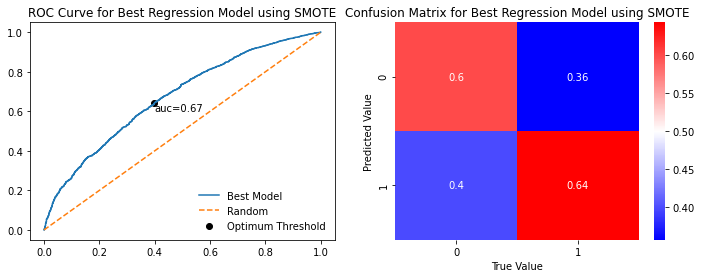

In [28]:
# fit best model to resampled data
grid_smote.best_estimator_.fit(X_resampled, y_resampled)

# calculate probabilities
probs_resampled = grid_smote.best_estimator_.predict_proba(X_test)

# calculate false positives, true positives for different thresholds
fp, tp, threshold = roc_curve(y_test, probs_resampled[:,1])

# calculate auc scoring metric
auc = roc_auc_score(y_test, probs_resampled[:,1])

# calculate gmeans metric and identify optimum threshold
gmeans = (tp * (1 - fp)) ** 0.5
ix = np.argmax(gmeans)
opt_threshold = threshold[ix]

# predict class labels using optimum threshold
predict = np.where(probs_resampled[:,1] >= opt_threshold, 1, 0)

# plot roc curve and confusion matrix for SMOTE model
conf = confusion_matrix(y_test, predict).T
conf = conf.astype('float') / conf.sum(axis=0)

fig, ax = plt.subplots(1, 2)
fig.set_figwidth(12)
ax[0].plot(fp, tp, label='Best Model')
ax[0].plot([0,1], [0,1], linestyle='--', label='Random')
ax[0].scatter(fp[ix], tp[ix], marker='o', color='black', label='Optimum Threshold')
ax[0].text(0.4, 0.6, 'auc={}'.format(round(auc, 2)))
ax[0].set_title('ROC Curve for Best Regression Model using SMOTE')
ax[0].legend(loc='lower right', frameon=False)
sns.heatmap(conf, annot=True, cmap='bwr', ax=ax[1])
ax[1].set_xlabel('True Value')
ax[1].set_ylabel('Predicted Value')
ax[1].set_title('Confusion Matrix for Best Regression Model using SMOTE')

Applying SMOTE actually reduced the performance of the model as the AUC score has decreased and false positive rate has increased.

# Conclusion

In this project I have explored the possibility of predicting whether a borrow will pay back a loan on time using Lending Club data and machine learning techniques. The dataset was imbalanced with a positive class imbalance of 6:1.

It was found that logistic regression with balanced class weights was the best model. Applying a grid search and using the optimum threshold an AUC score of 0.71 was acheived, with good true positive and true negative rates.

In the context of the project, an investor can be fairly confident using this model that they will not lose money when investing in a loan that is predicted to be paid back on time.